# Introduction

This IPython notebook demonstrates using the package `py_clifford` to setup, train and test recurrent neural networks (RNNs) to simulate the 2-line visual discrimination task as described in [[Ding, et. al. 2017]](https://www.pnas.org/content/114/43/E9115). The following from that paper figure summarized this experiment:

<img src="figs/twolineppexp_ding.png" alt="2-line Visual Discrimination Experiment" style="width: 600px;"/>

First, we need to import `py_clifford` package and other libraries as follows:

In [1]:
import sys
sys.path.append('/proj/retroviz-PG0/py_clifford/')

In [2]:
import py_clifford as cliff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Initialization

Next, we read a configuration file which describes the input and output properties as well as network configurations. We will describe these settings [later in this notebook](#Experimental-Configurations). To load a configuration file, we use the `load_configs` function as follows:

In [3]:
# Read config file in JSON format

from py_clifford.utils.generic_helper import get_install_path

datasets_path   = os.sep.join([get_install_path(), 'tests', 'test_datasets'])
config_filename = os.sep.join([datasets_path, 'test_firing_rate_rnn_config_2.json'])
config          = cliff.load_configs(config_filename)

The `config` object is a dictionary of key-values. For example, we can retirieve the number of firing rate units we wish to use in our RNN as follows:

In [4]:
config['network_params']['hidden_params']['num_hidden_units']

100

We can change the network parameters by changing the values of this dictionary. For example, we can set the nonlinearity of the hidden units as:

In [5]:
config['network_params']['hidden_params']['activation_function'] = 'tanh'

We then create a `VisualDiscriminationFRRNN` object which takes the `config` object as the input to its only constructor.

In [6]:
# Create a firing rate RNN to simulate the 2-line visual discriminatuoin task
visdisfrrnn     = cliff.VisualDiscriminationFRRNN(config)

W0419 22:42:22.497248 140415221454592 deprecation_wrapper.py:119] From /proj/retroviz-PG0/py_clifford/py_clifford/vis_dis_frrnn.py:28: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0419 22:42:22.518585 140415221454592 deprecation.py:323] From /proj/retroviz-PG0/py_clifford/py_clifford/vis_dis_frrnn.py:93: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0419 22:42:22.639301 140415221454592 deprecation.py:506] From /proj/retroviz-PG0/py_clifford/py_clifford/firing_rate_rnn.py:86: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The following figure illustrates the architecture of a typical network we train.

<img src="figs/network_arch_4.png" alt="Network Architecture" style="width: 600px;"/>

## Training

Next, we reduce the number of training steps and epochs for the purpose of this presentation as follows:

In [7]:
visdisfrrnn._training_steps    = 10
visdisfrrnn._num_epochs        = 2

Now we train the RNN by calling its `train` function:

In [8]:
visdisfrrnn.train()

If we wish to save the model to the disk, we can `config['persistence_params']['save_weights'] = True`. If so, the model weights will be saved to disk at a frequency determined by `config['persistence_params']['save_step']`.

## Testing

We now test the model we trained above for a specific combination of input orientations, that is, the first orientation $\theta_1=45^{\circ}$ and the second orientation $\theta_2=60^{\circ}$.

In [9]:
visdisfrrnn._testing_batch_size        = 1
testing_output, hidden_units_activity_tensor, error, s1s, s2s, X, Y  = visdisfrrnn.test(45, 60)

We then plot the testing results.

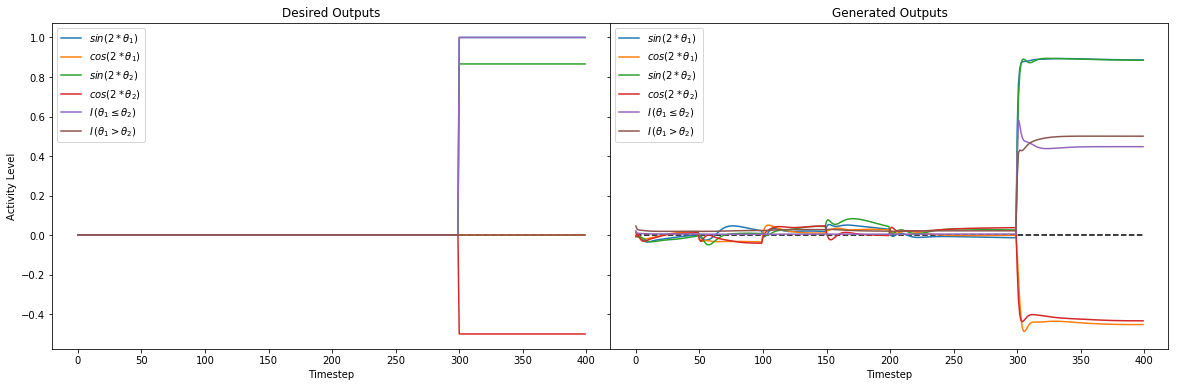

In [7]:
%matplotlib inline

def plot_prediction_samples(generated_output, correct_output):
    fig, axs = plt.subplots(nrows=1, 
                            ncols=2, 
                            sharey=True, 
                            figsize=(20,6),
                            gridspec_kw={'hspace': 0, 'wspace': 0},
                           )

    output_labels = [r'$sin(2*\theta_1)$',
                     r'$cos(2*\theta_1)$',
                     r'$sin(2*\theta_2)$',
                     r'$cos(2*\theta_2)$',
                     r'$I\,(\theta_1 \leq \theta_2)$',
                     r'$I\,(\theta_1 > \theta_2)$',
                    ]

    axs[0].plot(range(correct_output.shape[1]), [0,]*correct_output.shape[1], 'k--')

    for jj in range(correct_output.shape[2]):
        axs[0].plot(range(correct_output.shape[1]), 
                    correct_output[0, :, jj].squeeze(), 
                    label=output_labels[jj])
    axs[0].set_xlabel("Timestep")
    axs[0].set_ylabel("Activity Level")
    axs[0].set_title("Desired Outputs")
    axs[0].legend()

    axs[1].plot(range(generated_output.shape[1]), [0,]*generated_output.shape[1], 'k--')
    for jj in range(generated_output.shape[2]):
        axs[1].plot(range(generated_output.shape[1]), 
                    generated_output[0, :, jj].squeeze(), 
                    label=output_labels[jj])
    axs[1].set_xlabel("Timestep")
    axs[1].set_title("Generated Outputs")
    axs[1].legend()

    plt.show()
    
plot_prediction_samples(testing_output, Y)

## Saving and Loading Models

As expected, the output generated by our model is far from the desired output as the number of trining steps were too low. We can uncomment and run the code in the following cell to run the training for 1000 steps. We have saved the results in the `test_save_path` folder.

In [11]:
# datasets_path   = os.sep.join([get_install_path(), 'tests', 'test_datasets'])
# config_filename = os.sep.join([datasets_path, 'test_firing_rate_rnn_config_3.json'])
# config          = cliff.load_configs(config_filename)
# models_path     = os.sep.join([get_install_path(), 'tests', 'models'])
# test_save_path  = os.sep.join([models_path, "test_save_load_vis_dis_frrnn_model_3"])

# visdisfrrnn             = cliff.VisualDiscriminationFRRNN(config)
# visdisfrrnn._save_path  = test_save_path

# visdisfrrnn.train()

We now load the model trained above from the corresponding folder using the `load_model` function and use it to run the same test trial as above.

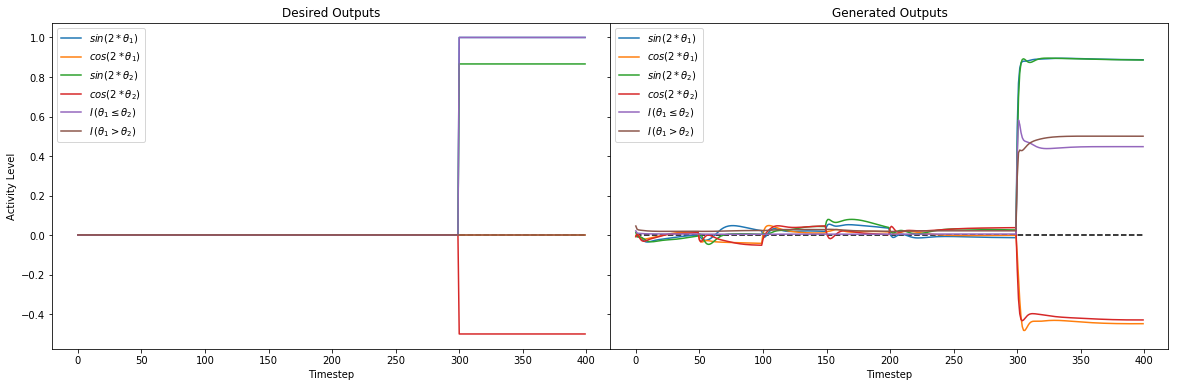

In [8]:
datasets_path   = os.sep.join([get_install_path(), 'tests', 'test_datasets'])
config_filename = os.sep.join([datasets_path, 'test_firing_rate_rnn_config_3.json'])
config          = cliff.load_configs(config_filename)
models_path     = os.sep.join([get_install_path(), 'tests', 'models'])
model_load_path = os.sep.join([models_path, "test_save_load_vis_dis_frrnn_model_3"])

visdisfrrnn             = cliff.VisualDiscriminationFRRNN(config)

visdisfrrnn.load_model(model_load_path)

visdisfrrnn._testing_batch_size        = 1
testing_output, hidden_units_activity_tensor, error, s1s, s2s, X, Y  = visdisfrrnn.test(45, 60)
plot_prediction_samples(testing_output, Y)

As we can observe the generated output looks much more like the desired output. We can also see the training loss and and validation accuracy plotted as a PNG file called `loss_acc.png` in the same model folder.

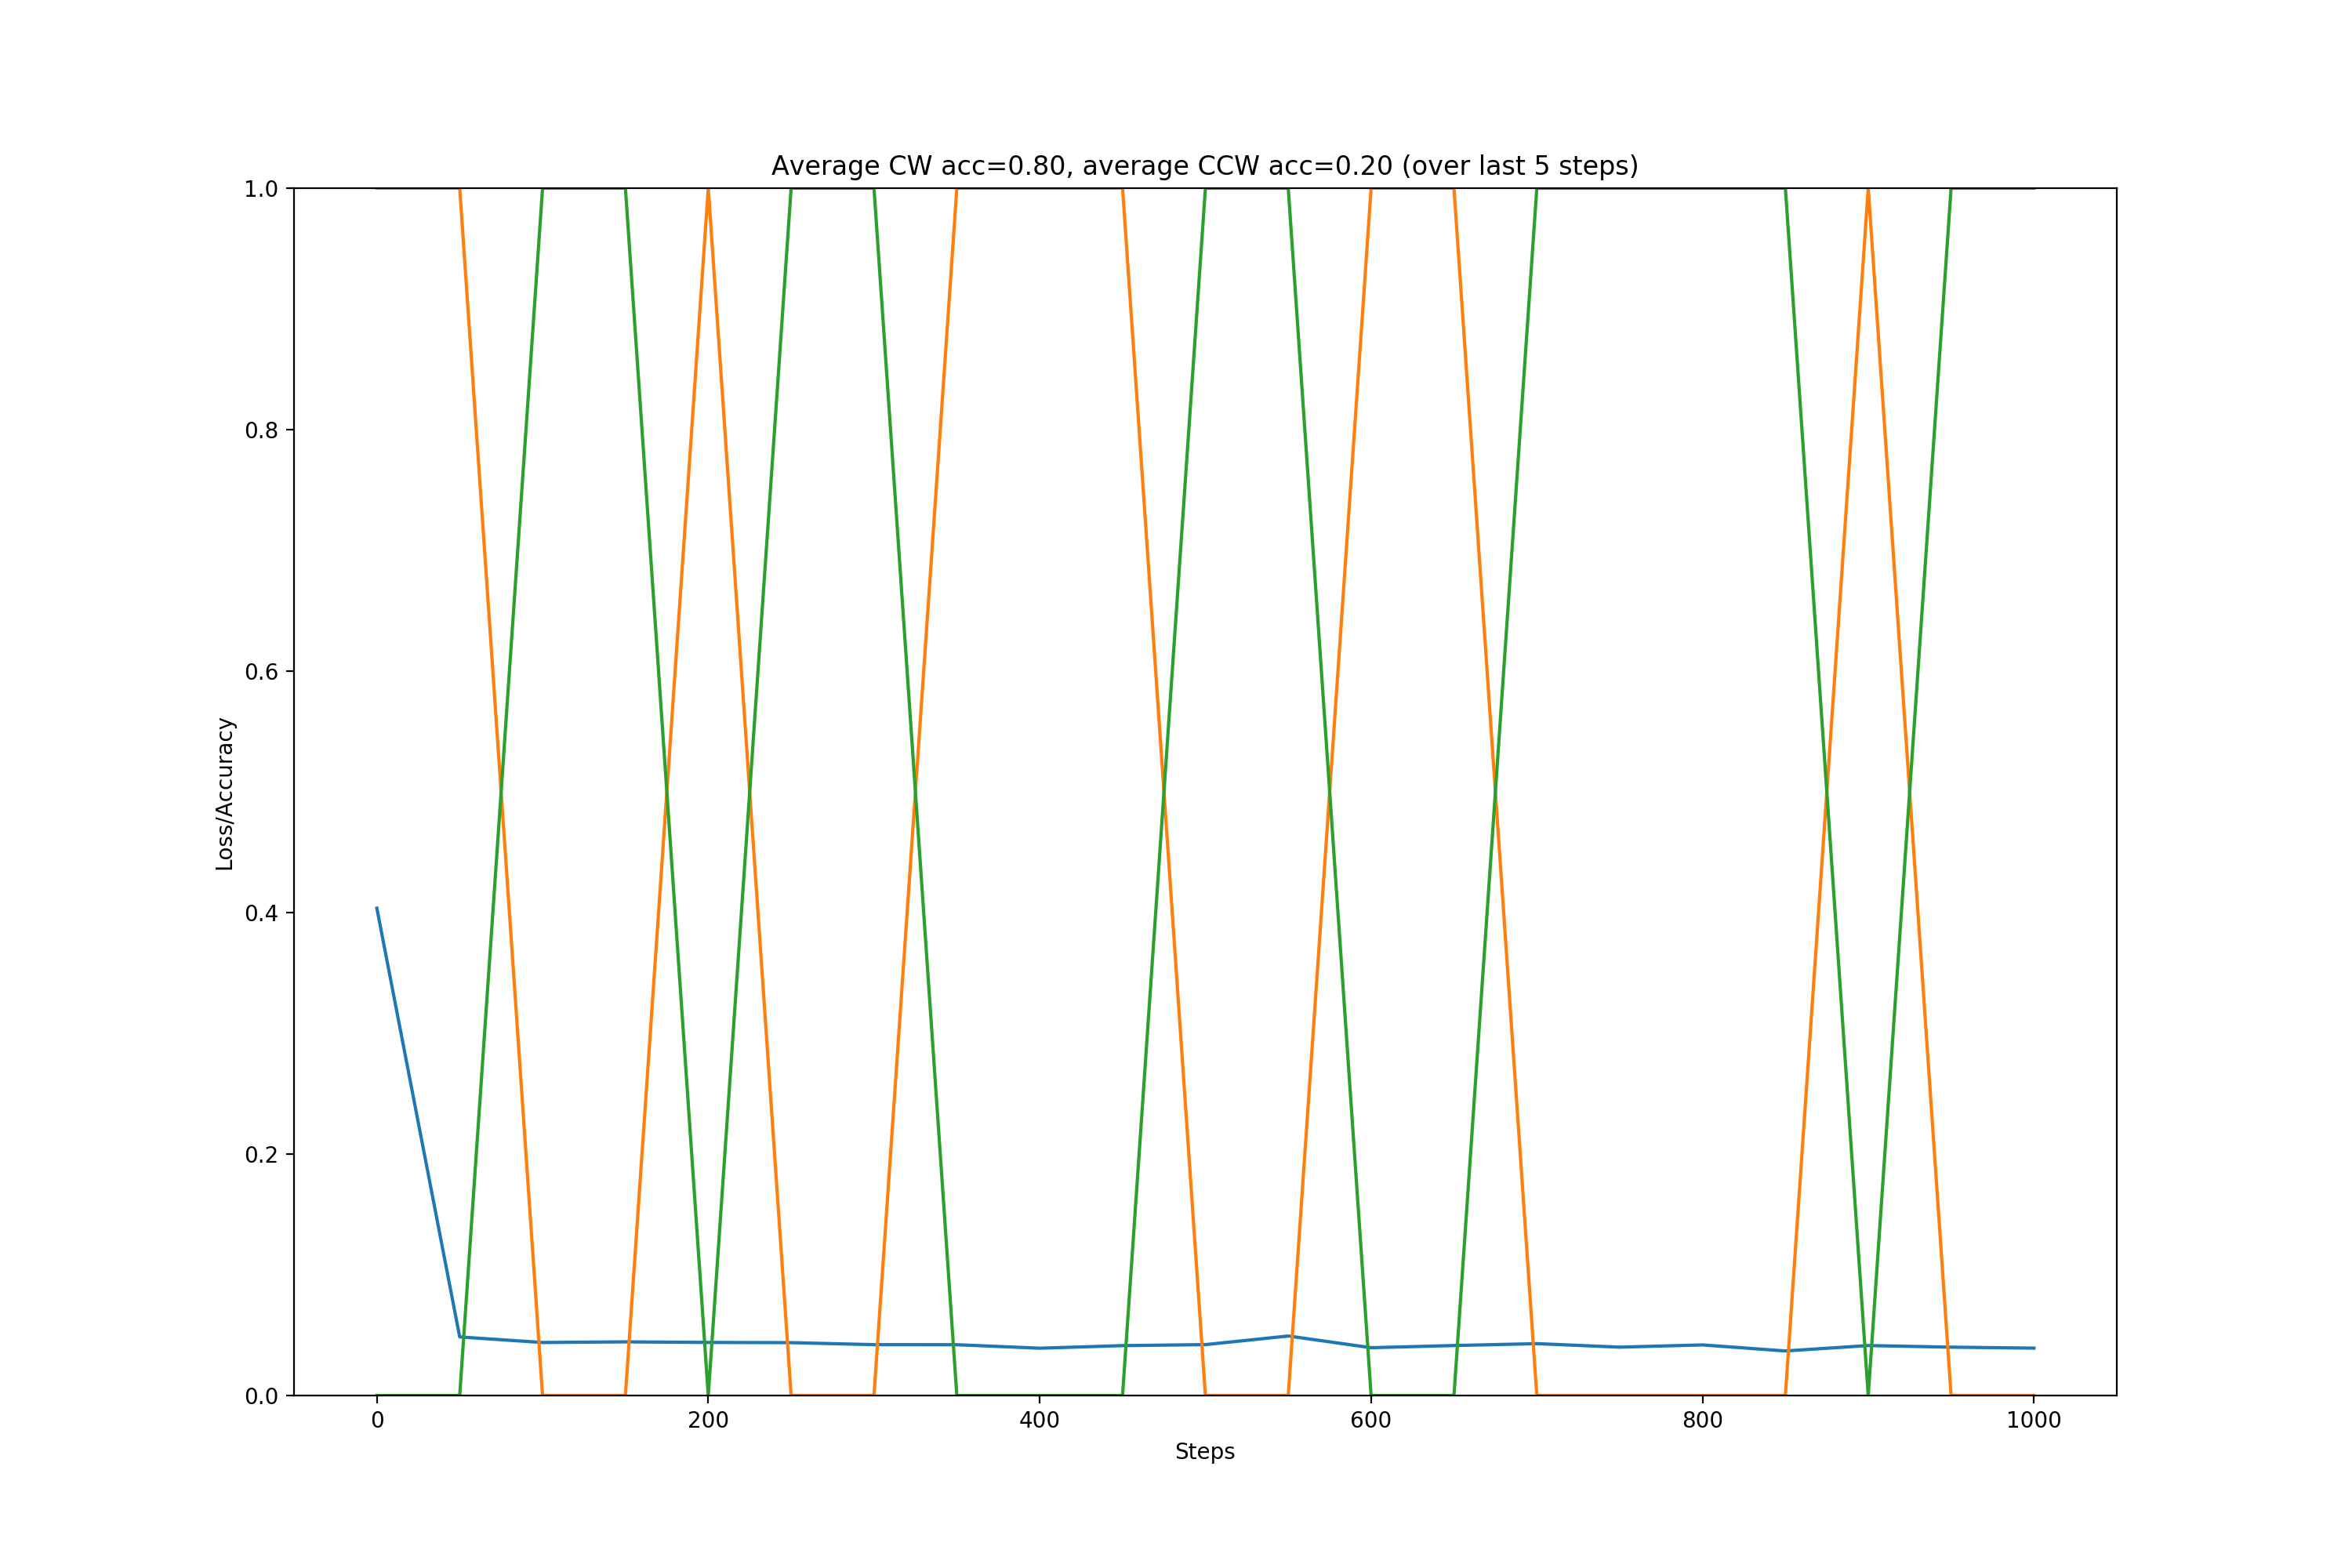

In [9]:
from IPython.display import Image
Image(filename=model_load_path+'/loss_acc.png')

For even better results, we let the training procedure continue for 20K steps and save the model.

In [10]:
# datasets_path   = os.sep.join([get_install_path(), 'tests', 'test_datasets'])
# config_filename = os.sep.join([datasets_path, 'test_firing_rate_rnn_config_2.json'])
# config          = cliff.load_configs(config_filename)
# models_path     = os.sep.join([get_install_path(), 'tests', 'models'])
# test_save_path  = os.sep.join([models_path, "test_save_load_vis_dis_frrnn_model_2"])

# visdisfrrnn             = cliff.VisualDiscriminationFRRNN(config)
# visdisfrrnn._save_path  = test_save_path

# visdisfrrnn.train()

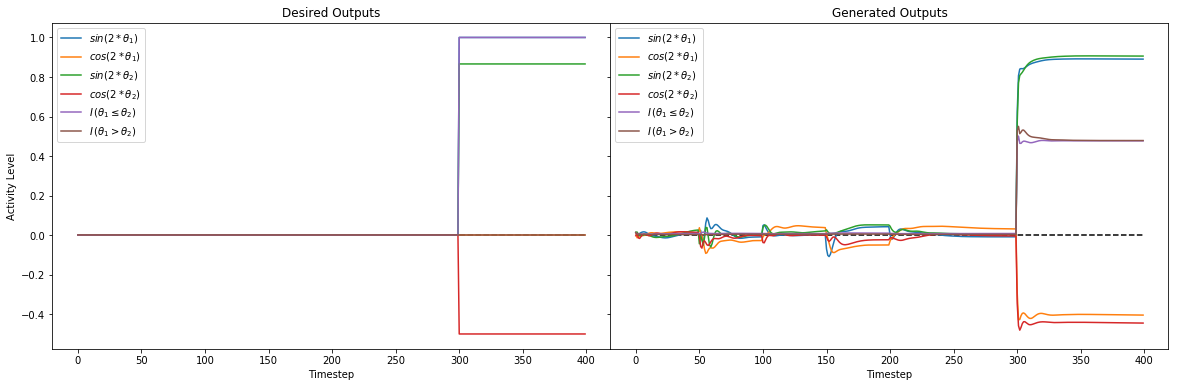

In [11]:
datasets_path   = os.sep.join([get_install_path(), 'tests', 'test_datasets'])
config_filename = os.sep.join([datasets_path, 'test_firing_rate_rnn_config_2.json'])
config          = cliff.load_configs(config_filename)
models_path     = os.sep.join([get_install_path(), 'tests', 'models'])
model_load_path = os.sep.join([models_path, "test_save_load_vis_dis_frrnn_model_2"])

visdisfrrnn             = cliff.VisualDiscriminationFRRNN(config)

visdisfrrnn.load_model(model_load_path)

visdisfrrnn._testing_batch_size        = 1
testing_output, hidden_units_activity_tensor, error, s1s, s2s, X, Y  = visdisfrrnn.test(45, 60)
plot_prediction_samples(testing_output, Y)

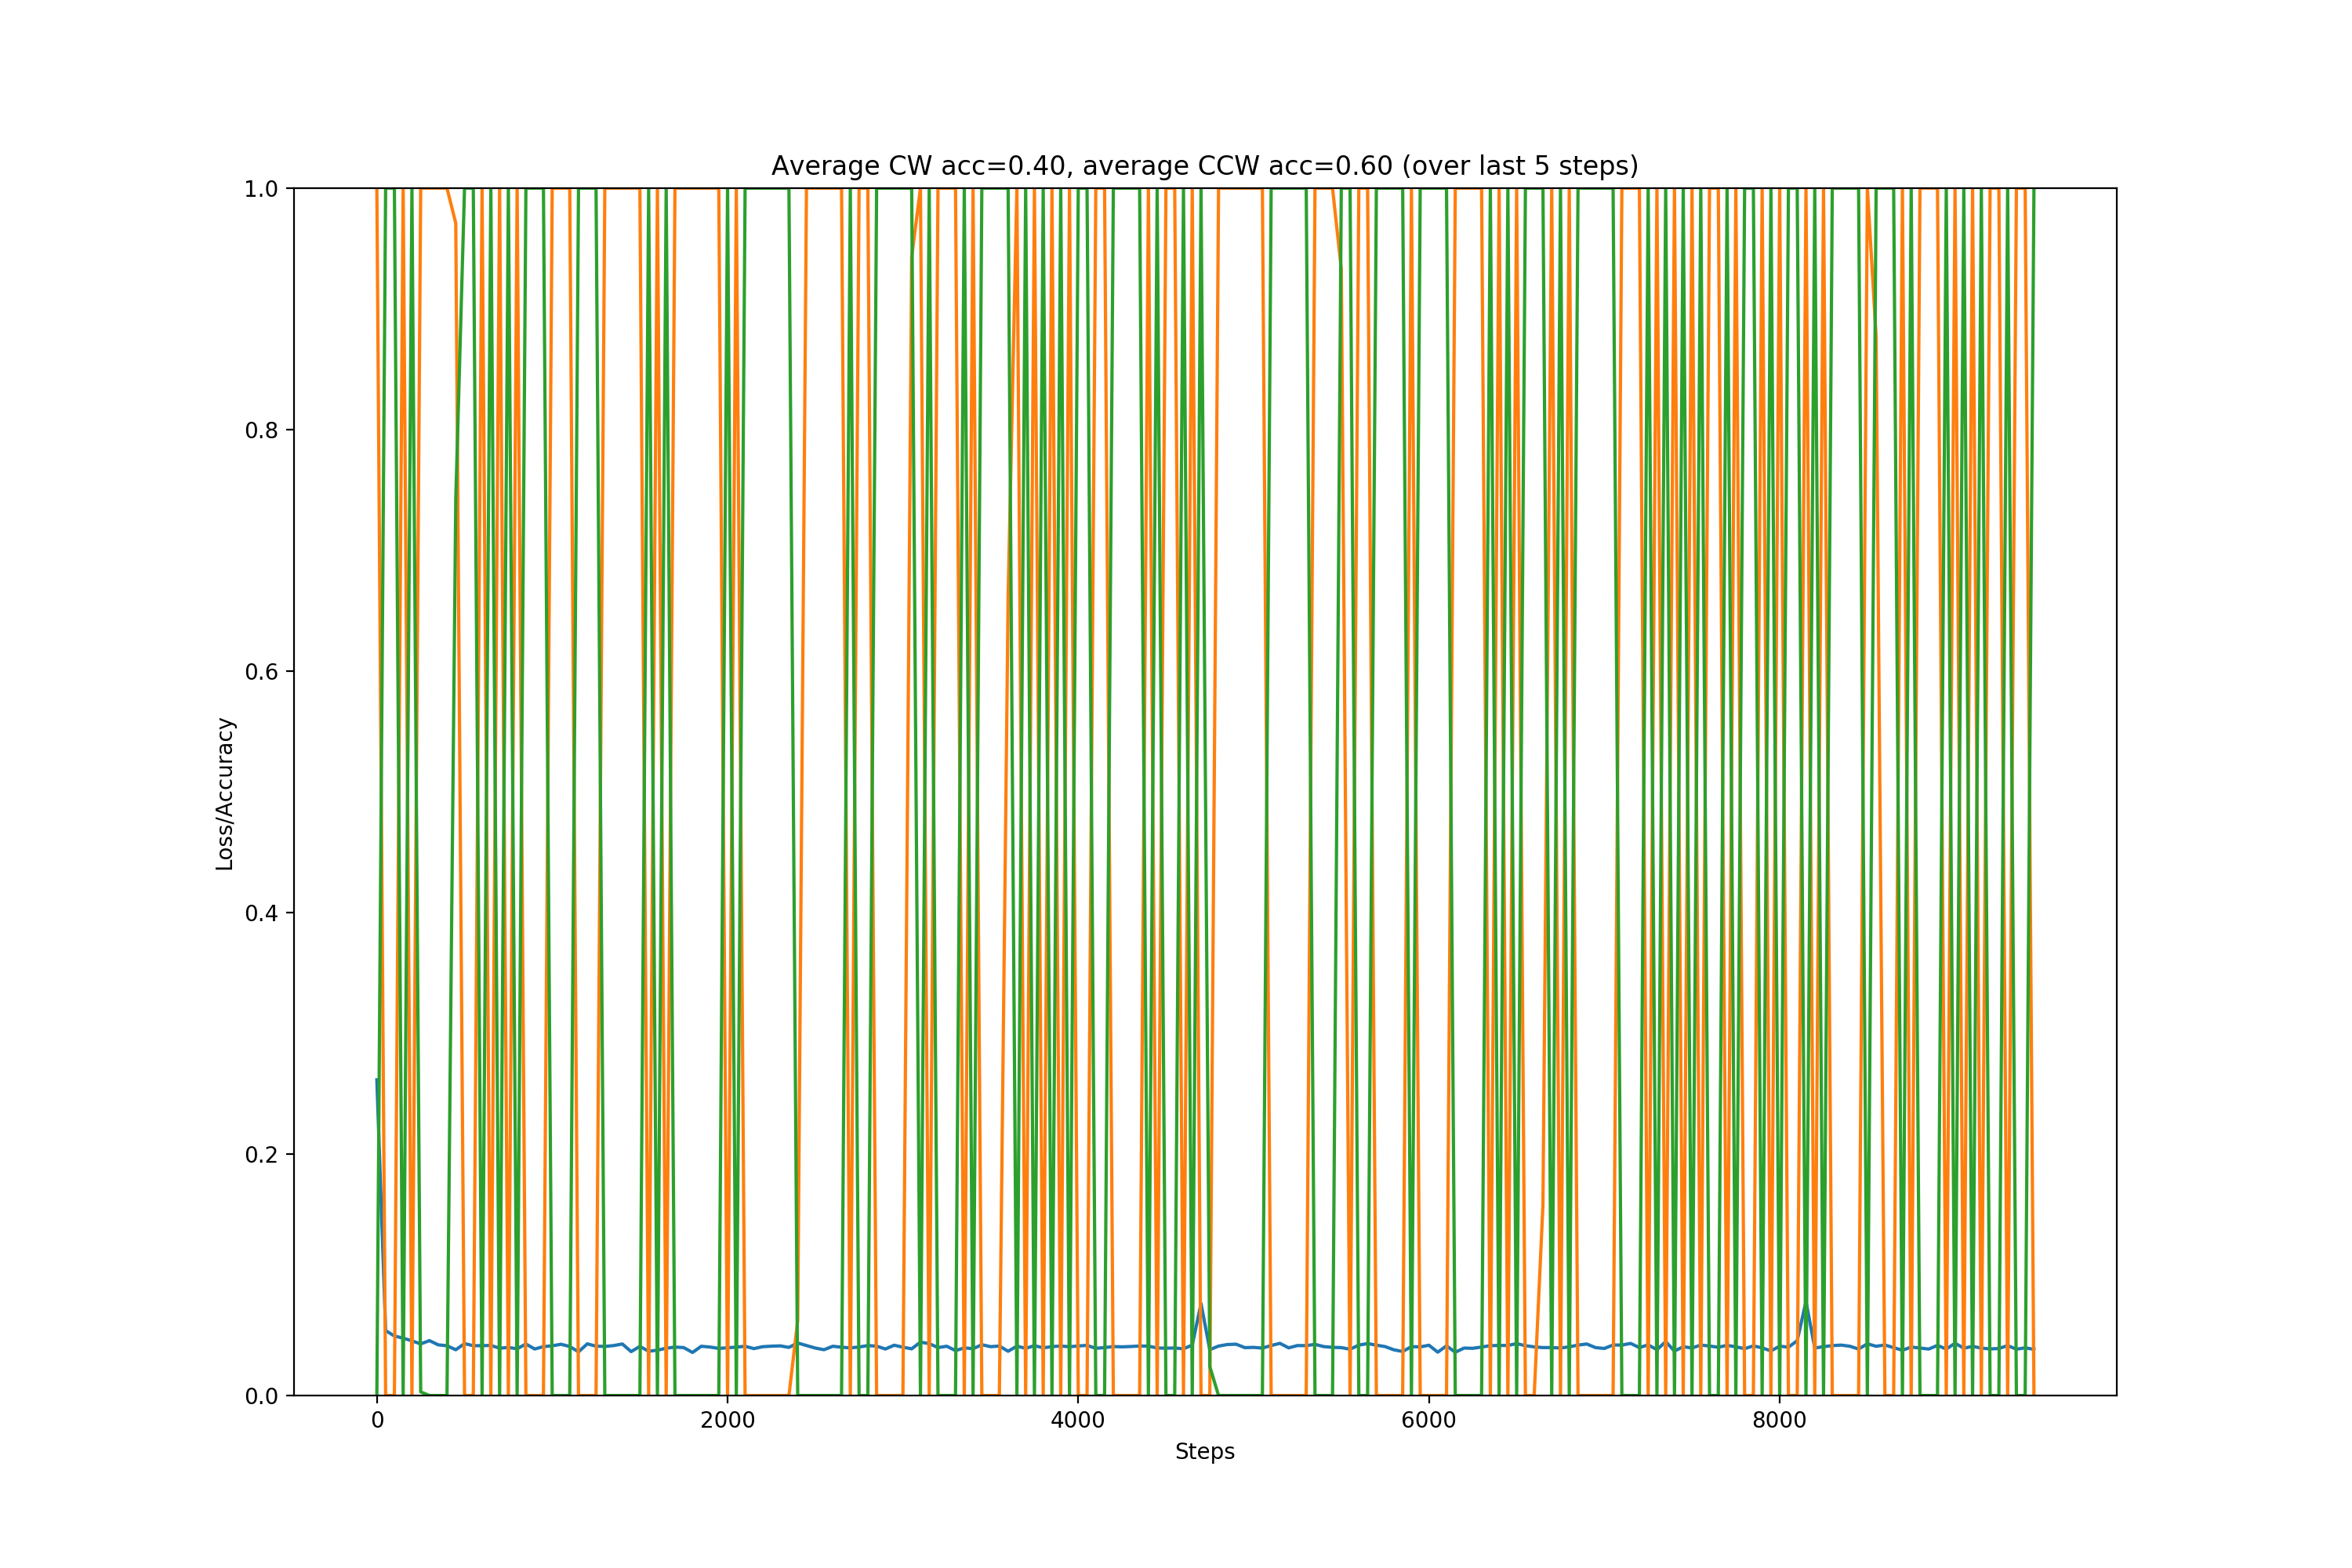

In [12]:
from IPython.display import Image
Image(filename=model_load_path+'/loss_acc.png')

# Experimental Configurations

In this section, we desribe various ways in which we can configure our model using parameter settings in the JSON config file. The configuration file consists of various sections, each determining the parameters of a different aspect of the experiments and simulations.

The **model configurations** are determined in the `network_params` section which is divided into three subsections:

1. `input_params`:
    - `num_orituned_input_units`: number of input units. The value of this parameter detemines the granularity of converting input orientations into simulated responses of orientation-tuned V1 cells.
    - `has_go_cue_unit`: whether we want to include an explicit go cue signal in the input, or we want the appearence of the second input orientation in each trial to act as an implicit go cue.
2. `hidden_params`: We currently support a single layer of firing rate hidden units.
    - `num_hidden_units`: number of firing rate units in the hidden layer
    - `activation_function`: nonlinearity applied to at each hidden unit. Common activation functions are:
        - $\tanh$: `tanh`
        - Rectified linear: `relu`
        - Linear: `linear`
        - Rectified $\tanh$: `lambda x: relu(tanh(x))`
    - `dtovertau`: inverse of the firing rate network time constant in the equation $ds=\frac{dt}{\tau} (-s +W f(s)+ Ax + b)$
    - `w_initializer`: determines the initialization method of the hidden layer weights
    - `layer_normalize`: whether to apply layer normalization to the output of the hidden layer
3. `output_params`:
    - `num_sincos_output_units`:  number of absolute judgement output units. For our experiments, this number is always equal to 4.
    - `num_ordinal_output_units`: number of ordinal judgement output units. We can have not ordinal output (`0`), one ordinal output (`1`) with 1 corresponding to CCW and -1 corrsponding to CW decisions, or two, one-hot, ordinal outputs (`2`).
    - `sincos_activation_function`: activation function of the absolute judgement output units
    - `ordinal_activation_function`: activation function of the ordinal judgement output units
    - `output_linear`: whether to ignore the output activation functions

The **model training and evaluation parameters** are organized into three sections: (1) `training_params`, (2) `testing_params`, and (3) `validation_params`.

1. `training_params`: Currently, we only support the [Adam](https://arxiv.org/abs/1412.6980) algorithm
    - `learning_rate`: learing rate of the RNN training algorithm
    - `training_steps`: total number of training steps
    - `batch_size`: size of each training batch. These batches can be created using various strategies (see below).
    - `num_epochs`: number of time each training batch is used to train the RNN at each step
    - `adam_beta1`, `adam_beta2`: [Adam](https://arxiv.org/abs/1412.6980) algorithm's parameters $\beta_1$ and $\beta_2$
2. `testing_params`:
    - `batch_size`: size of each testing batch
    - `read_linear_hidden_activity`: whether we want to read the hidden unit activities before (`true`) or after (`false`) applying the hidden units' nonlinearities
    - `integrate_response_window_size`: use the average of the last few outputs to determine the decision and measure loss and accuracy. This is done to make the results more robust to extraneous noise injected into hidden units activities.
3. `validation_params`:
    - `batch_size`: size of each validation batch
    - `validation_step`: determines teh frequency of running validation to track the improvement of the network accuracy

The **timing of the input trials** (in trials with non-random timing intervals) is determined by the `data_params` section:

- `timesteps`: total number of timesteps in each trial
- `s1_start`: start time of the first input orientation (relative to the beginning ot the trial)
- `s1_end`: end time of the first input orientation
- `s2_start`: start time of the second input orientation
- `s2_end`: end time of the second input orientation
- `go_cue`: start time of the go cue
- `hidden_units_noise_std`: determines the amount of "memory" noise injected into the hidden units
- `min_angular_diff`, `max_angular_diff`: minimum and maximum angular difference for gradually decreasing angular difference between the input orientations during training
- `sampling_annealing_const`: determines the rate by which the above angular difference decreases
- `random_orientation_sampling_prob`: probability of sampling both orientations randomly (instead of choosing the first orientation at random and then choosing the second orientation using the angular difference at this step)

The paramters in the `persistence_params` section determine saving and visualization configurations of the experiment:

- `display_step`: perform validation every `display_step` steps
- `save_step`: save the model parameters every `save_step` steps
- `save_weights`: whether to save model parameters or not
- `save_test_pointcloud`: whether to save testing pointclouds

The `logging_level` parameter determined the how verbose we want the logging system to be.
